In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier




# Preprocessing

In [5]:
pd.set_option('display.max_columns', None)

train = pd.read_parquet("UNSW_NB15_training-set.parquet")
test = pd.read_parquet("UNSW_NB15_testing-set.parquet")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                175341 non-null  float32 
 1   proto              175341 non-null  category
 2   service            175341 non-null  category
 3   state              175341 non-null  category
 4   spkts              175341 non-null  int16   
 5   dpkts              175341 non-null  int16   
 6   sbytes             175341 non-null  int32   
 7   dbytes             175341 non-null  int32   
 8   rate               175341 non-null  float32 
 9   sload              175341 non-null  float32 
 10  dload              175341 non-null  float32 
 11  sloss              175341 non-null  int16   
 12  dloss              175341 non-null  int16   
 13  sinpkt             175341 non-null  float32 
 14  dinpkt             175341 non-null  float32 
 15  sjit               175341 non-null

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dur                82332 non-null  float32 
 1   proto              82332 non-null  category
 2   service            82332 non-null  category
 3   state              82332 non-null  category
 4   spkts              82332 non-null  int16   
 5   dpkts              82332 non-null  int16   
 6   sbytes             82332 non-null  int32   
 7   dbytes             82332 non-null  int32   
 8   rate               82332 non-null  float32 
 9   sload              82332 non-null  float32 
 10  dload              82332 non-null  float32 
 11  sloss              82332 non-null  int16   
 12  dloss              82332 non-null  int16   
 13  sinpkt             82332 non-null  float32 
 14  dinpkt             82332 non-null  float32 
 15  sjit               82332 non-null  float32 
 16  djit

label
1    119341
0     56000
Name: count, dtype: int64


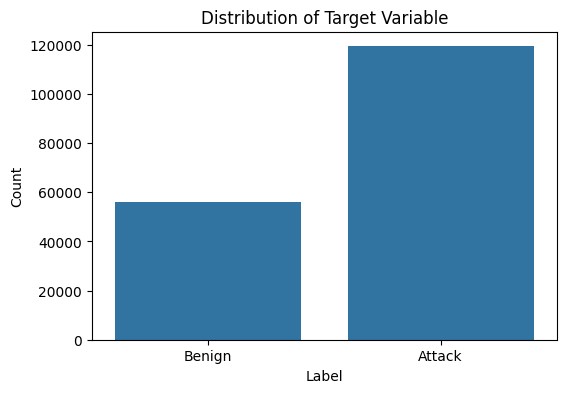

In [8]:
print(train['label'].value_counts())

plt.figure(figsize = (6, 4))
sns.countplot(x = 'label', data = train)
plt.title('Distribution of Target Variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.show()

label
1    45332
0    37000
Name: count, dtype: int64


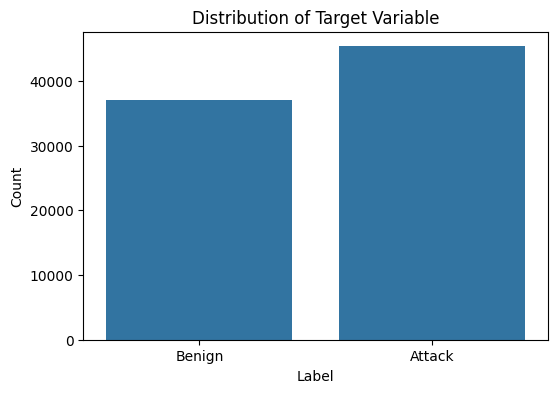

In [9]:
print(test['label'].value_counts())

plt.figure(figsize = (6, 4))
sns.countplot(x = 'label', data = test)
plt.title('Distribution of Target Variable')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.show()

In [10]:
train = train.drop(columns = ['attack_cat'])
test = test.drop(columns = ['attack_cat'])

In [11]:
# checking for unique values for categorical features

print(train['proto'].value_counts().shape)
print(train['service'].value_counts().shape)
print(train['state'].value_counts().shape)

(133,)
(13,)
(9,)


In [12]:
cc = ['service', 'state']
train = pd.get_dummies(train, columns = cc)

In [13]:
proto_train = train['proto']
train = train.drop(columns = ['proto'])


In [14]:
train = train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [15]:
train.head(5)

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_CON,state_ECO,state_FIN,state_INT,state_PAR,state_REQ,state_RST,state_URN,state_no
0,0.121478,6,4,258,172,74.087486,14158.942383,8495.365234,0,0,24.295601,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.649902,14,38,734,42014,78.473373,8395.112305,503571.312500,2,17,49.915001,15.432865,61.426933,1387.778320,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1.623129,8,16,364,13186,14.170161,1572.271851,60929.230469,1,6,231.875565,102.737206,17179.585938,11420.925781,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1.681642,12,12,628,770,13.677108,2740.178955,3358.622070,1,3,152.876541,90.235725,259.080170,4991.784668,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.449454,10,6,534,268,33.373825,8561.499023,3987.059814,2,1,47.750332,75.659599,2415.837646,115.806999,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [16]:
test = pd.get_dummies(test, columns = cc)
proto_test = test['proto']
test = test.drop(columns = ['proto'])
test = test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [17]:
test.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label,service_-,service_dhcp,service_dns,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,0.000011,2,0,496,0,90909.09375,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.000008,2,0,1762,0,125000.00000,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.000005,2,0,1068,0,200000.00000,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.000006,2,0,900,0,166666.65625,600000000.0,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.000010,2,0,2126,0,100000.00000,850400000.0,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
test = test.reindex(columns = train.columns, fill_value = 0)

In [19]:
y_train = train['label']
x_train = train.drop(columns = ['label'])

y_test = test['label']
x_test = test.drop(columns = ['label'])

In [20]:
model = RandomForestClassifier()
model.fit(x_train, y_train)
importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending = True)
sorted_importances = importances.sort_values(ascending=True)

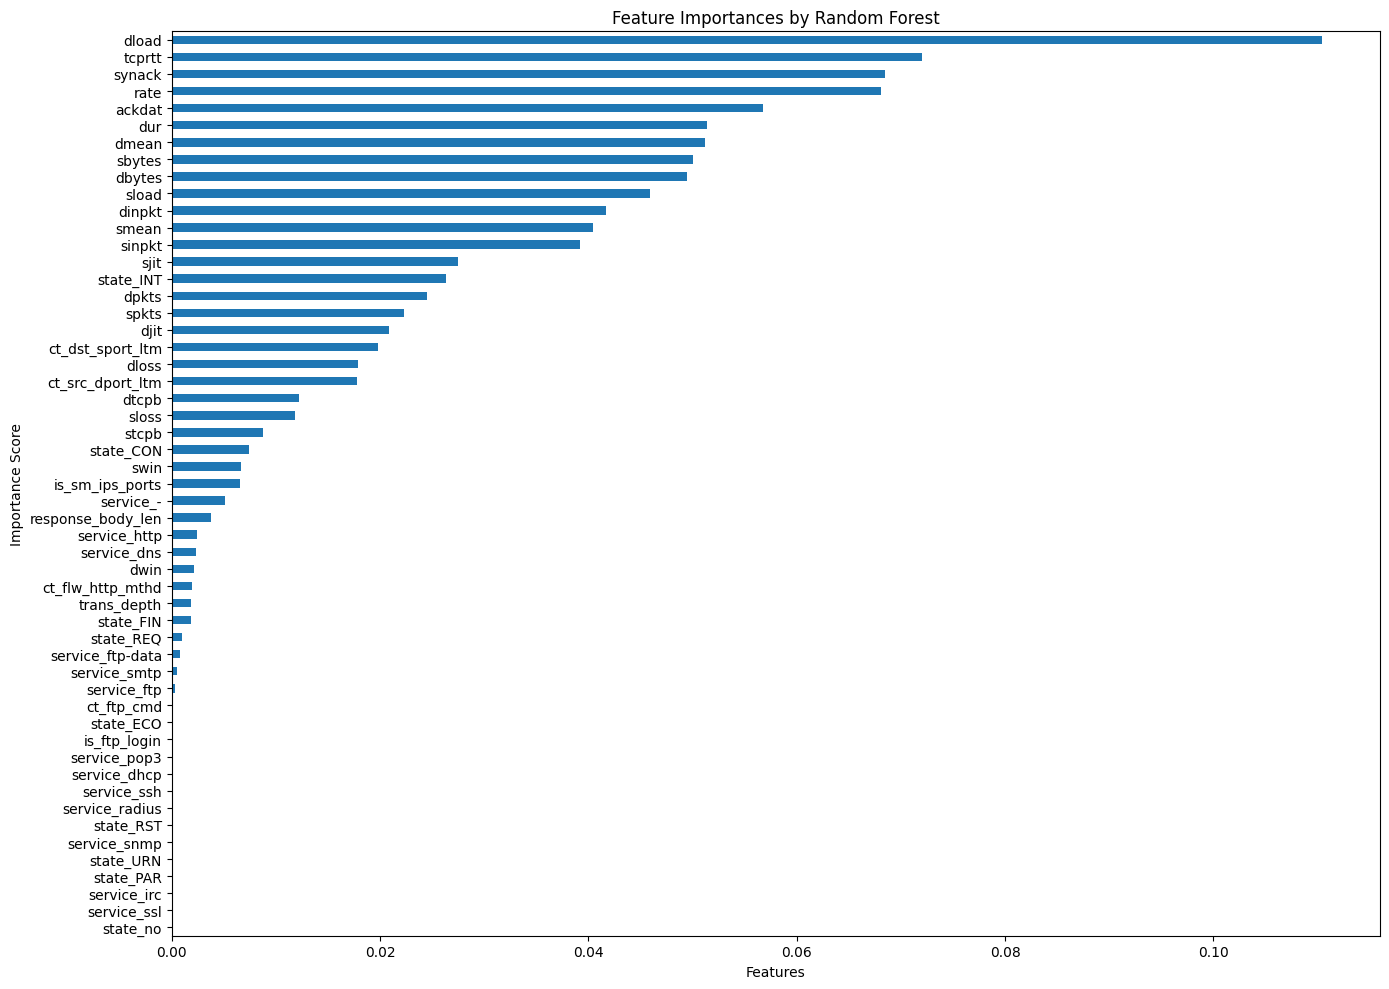

In [21]:
# Plot feature importances
plt.figure(figsize=(14, 10))
sorted_importances.plot(kind='barh')
plt.title("Feature Importances by Random Forest")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [22]:
top_features = sorted_importances[sorted_importances >= 0.02].index

In [23]:
x_train = x_train[top_features]
x_test = x_test[top_features]

In [24]:
print(x_train.shape)
print(x_test.shape)

(175341, 18)
(82332, 18)


In [25]:
x_train.head()

,djit,spkts,dpkts,state_INT,sjit,sinpkt,smean,dinpkt,sload,dbytes,sbytes,dmean,dur,ackdat,rate,synack,tcprtt,dload
0,11.830604,6,4,0,30.177547,24.295601,43,8.375000,14158.942383,172,258,43,0.121478,0.000000,74.087486,0.000000,0.000000,8495.365234
1,1387.778320,14,38,0,61.426933,49.915001,52,15.432865,8395.112305,42014,734,1106,0.649902,0.000000,78.473373,0.000000,0.000000,503571.312500
2,11420.925781,8,16,0,17179.585938,231.875565,46,102.737206,1572.271851,13186,364,824,1.623129,0.050439,14.170161,0.061458,0.111897,60929.230469
3,4991.784668,12,12,0,259.080170,152.876541,52,90.235725,2740.178955,770,628,64,1.681642,0.000000,13.677108,0.000000,0.000000,3358.622070
4,115.806999,10,6,0,2415.837646,47.750332,53,75.659599,8561.499023,268,534,45,0.449454,0.057234,33.373825,0.071147,0.128381,3987.059814


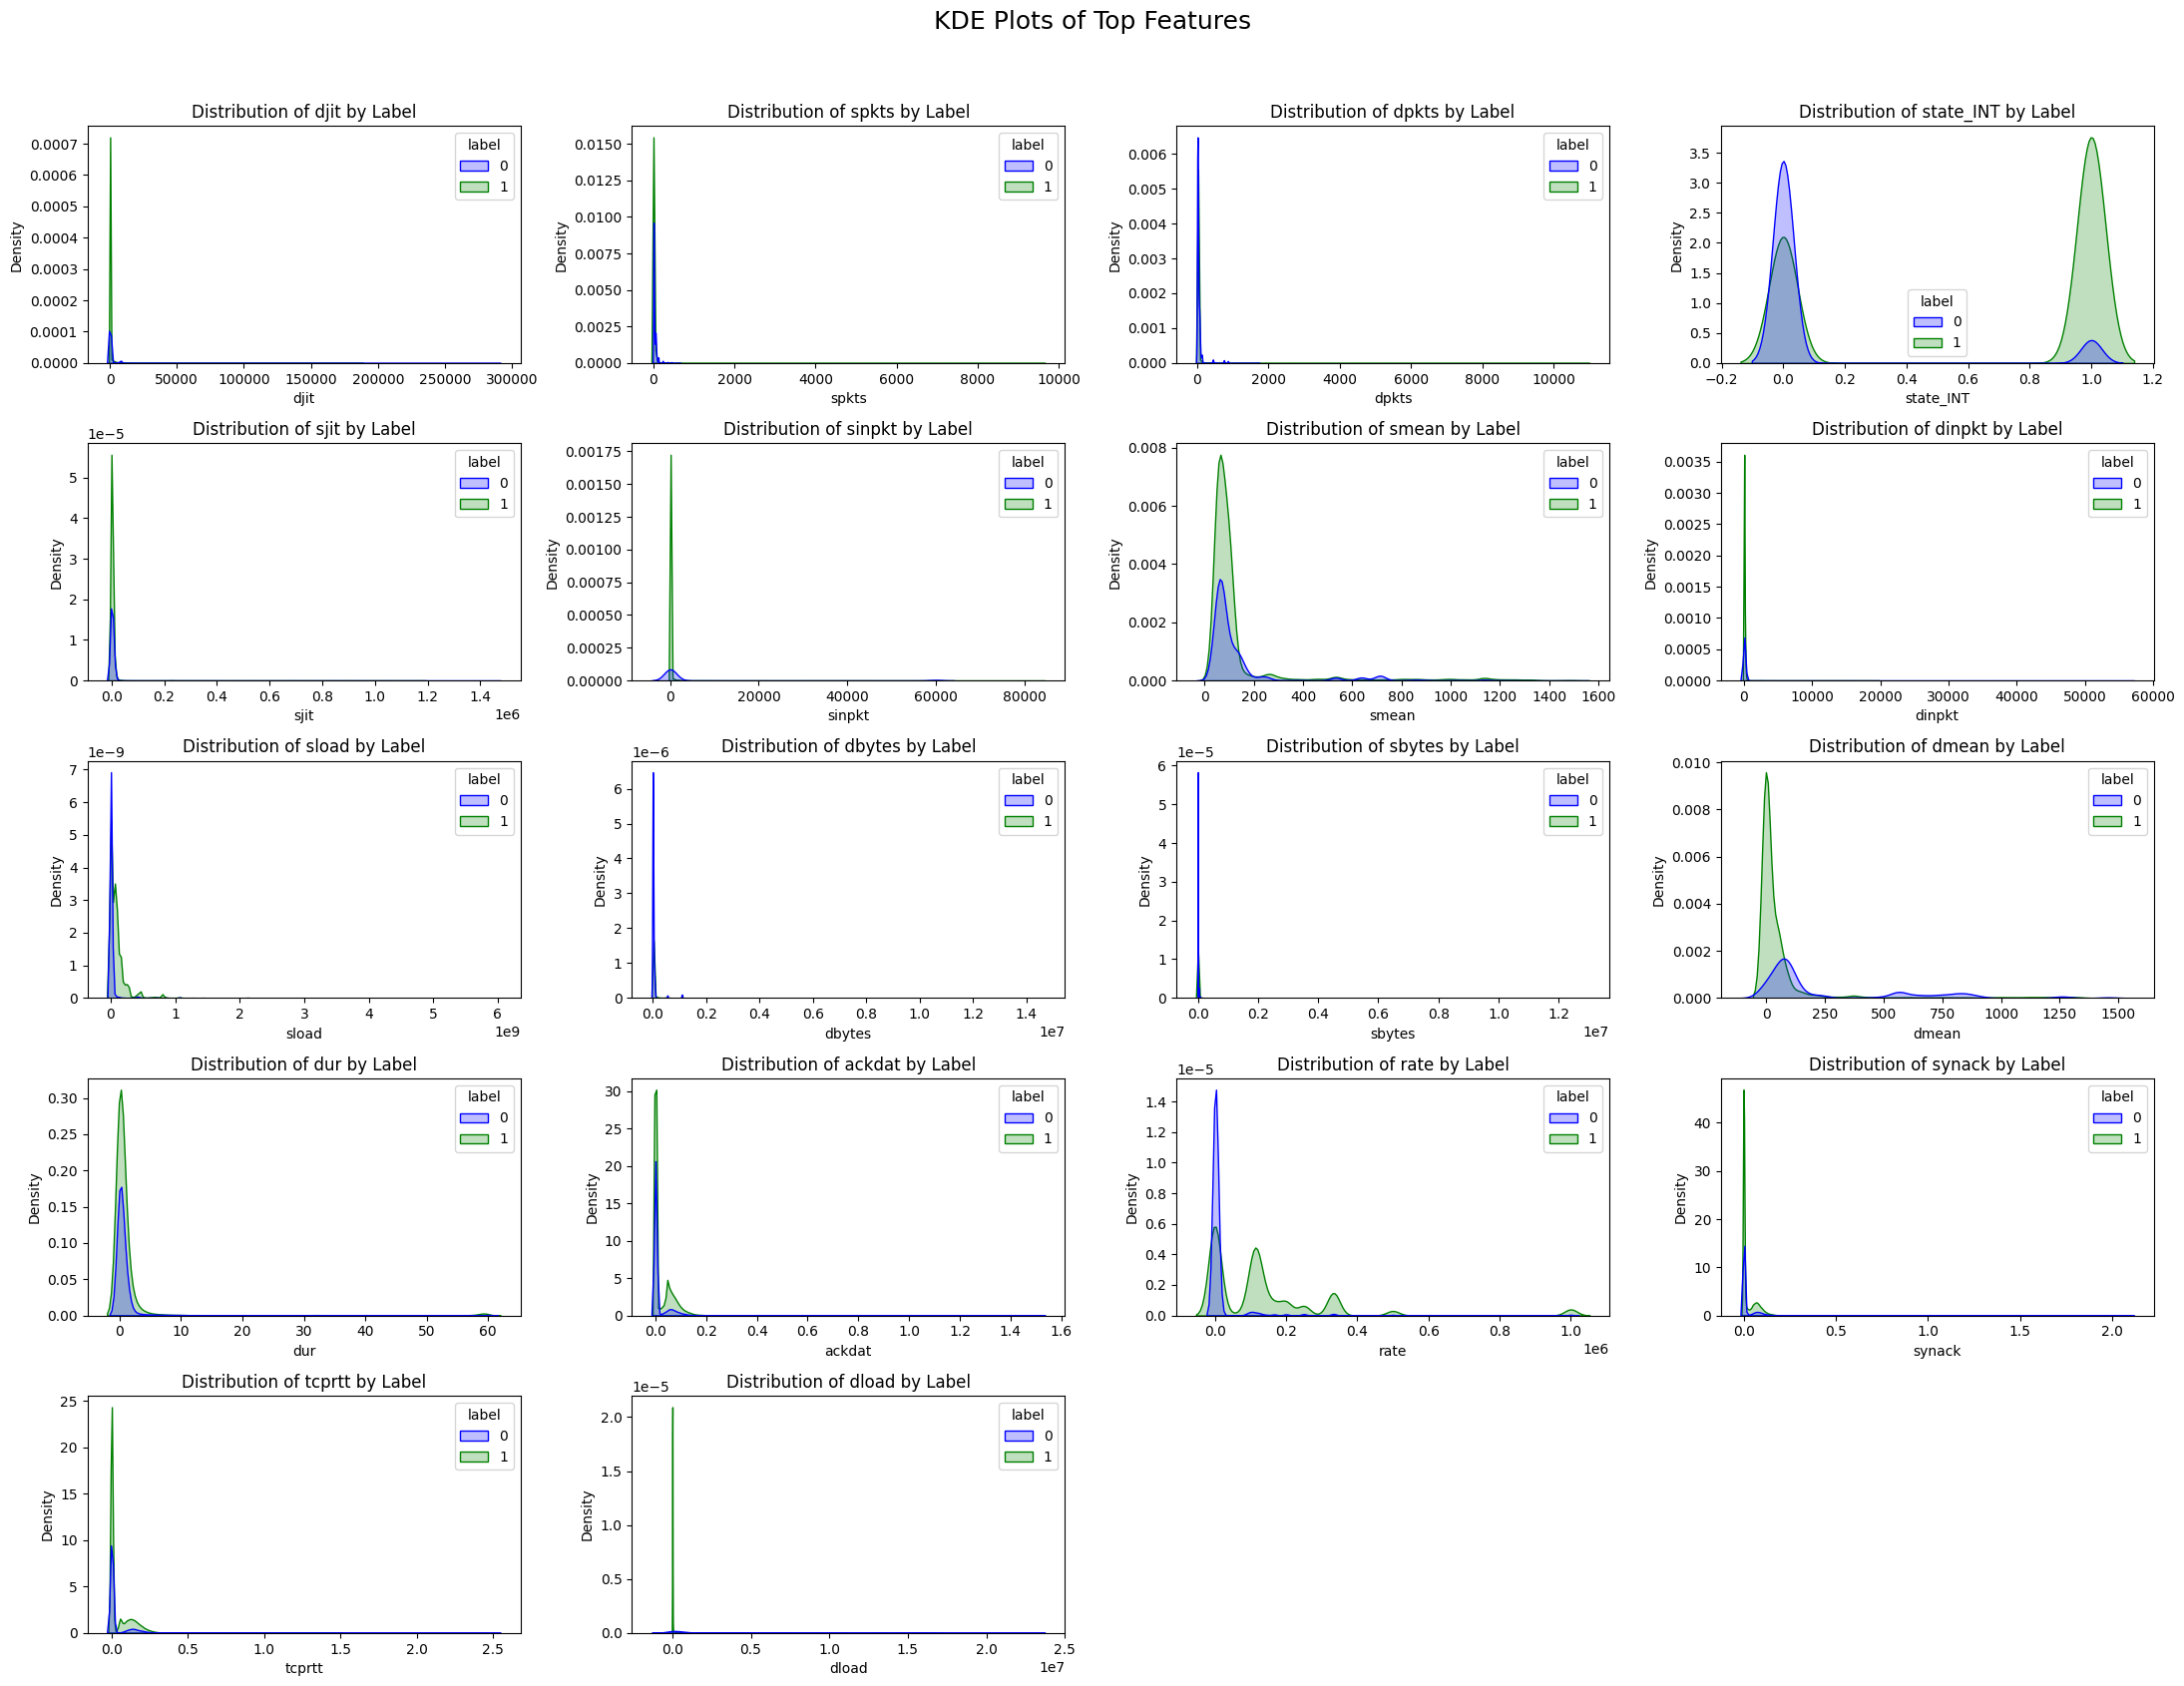

In [26]:
temp = pd.concat([x_train, y_train], axis = 1)

features = temp.columns[:-1]
n_features = len(features)

rows = 6 # Increased from 5 to accommodate all features
cols = 4


fig, axes = plt.subplots(rows, cols, figsize=(22, 20))
fig.suptitle('KDE Plots of Top Features', fontsize=18)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i] # Use the flattened index
    sns.kdeplot(data = temp, x = feature, hue='label', fill = True, ax = ax, palette={0: 'blue', 1: 'green'})
    ax.set_title(f'Distribution of {feature} by Label')

# Hide any unused subplots
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

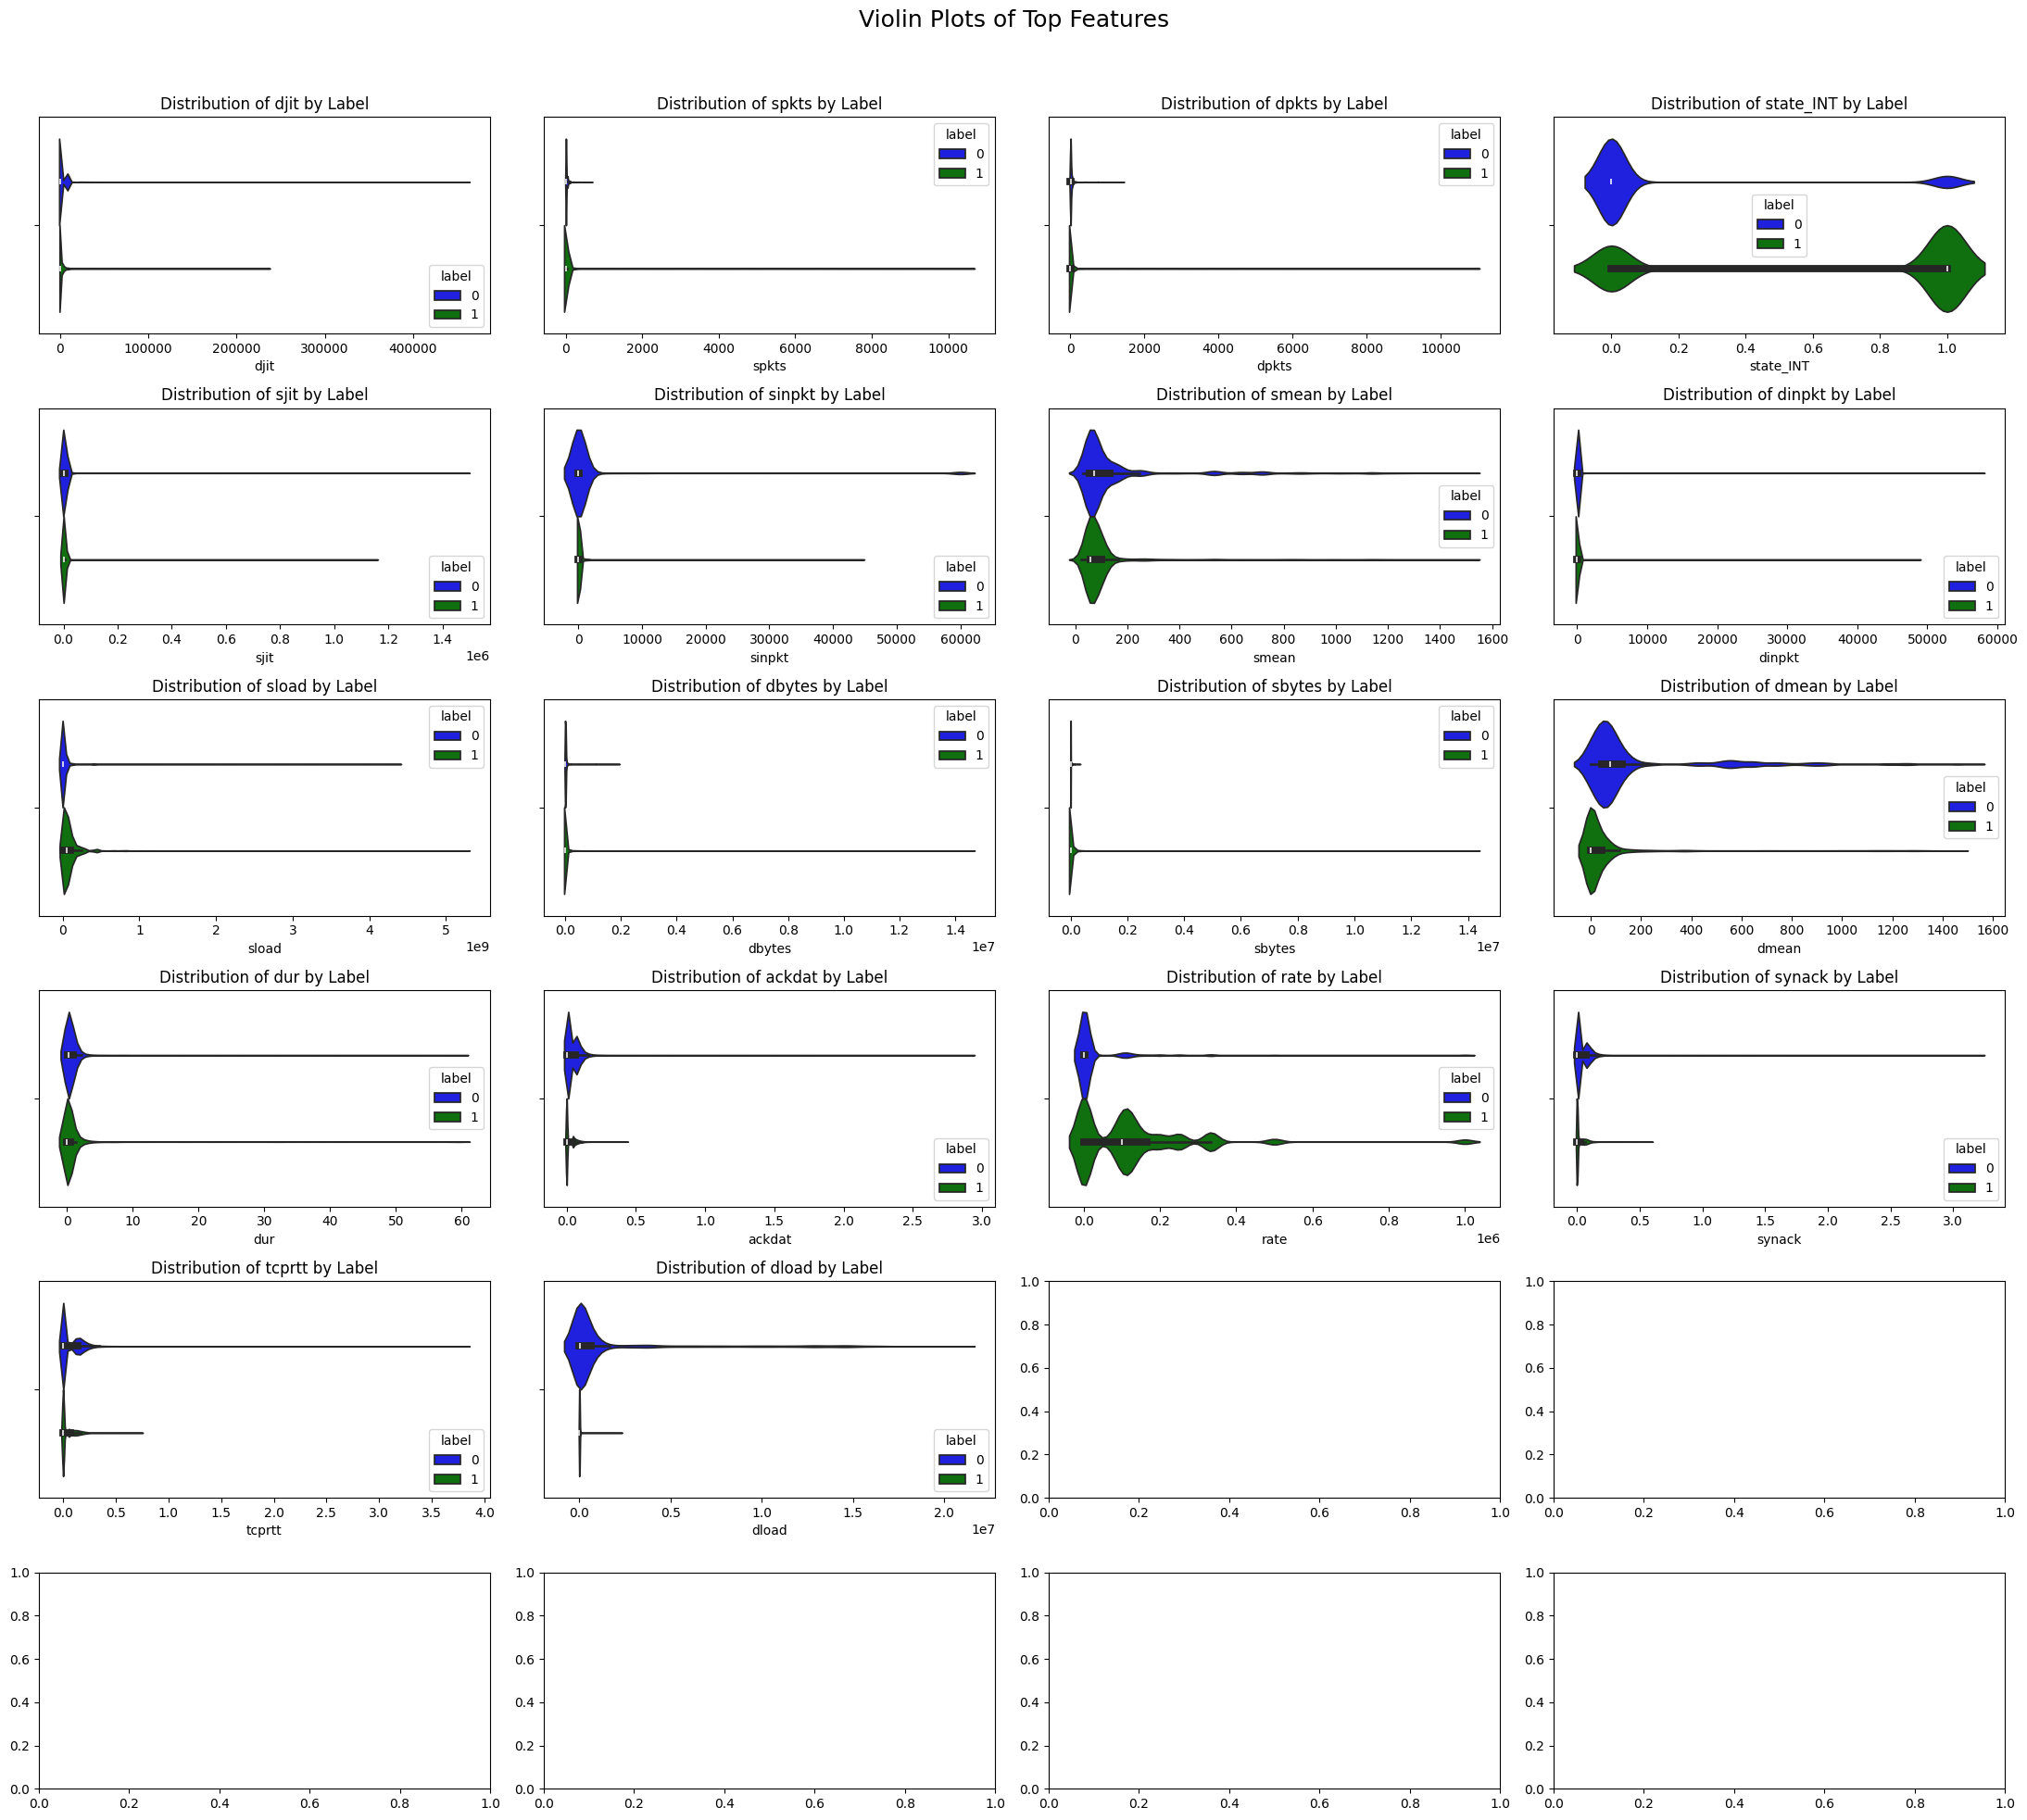

In [27]:
fig, axes = plt.subplots(rows, cols, figsize=(22, 20))
fig.suptitle('Violin Plots of Top Features', fontsize=18)

for i, feature in enumerate(features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    sns.violinplot(data = test, x = feature, hue='label', fill = True, ax = ax, palette={0: 'blue', 1: 'green'})
    axes[row, col].set_title(f'Distribution of {feature} by Label')


plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()




In [28]:
outlier_counts = {}
outlier_flags = pd.DataFrame(index = test.index)

for feature in features:
    Q1 = test[feature].quantile(0.25)
    Q3 = test[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    is_outlier = (test[feature] < lower) | (test[feature] > upper)
    outlier_counts[feature] = is_outlier.sum()
    outlier_flags[feature] = is_outlier


combined_outlier_mask = outlier_flags.any(axis = 1)
total_outlier_rows = combined_outlier_mask.sum()
outlier_counts_series = pd.Series(outlier_counts).sort_values(ascending = False)

print("Outlier count per feature:\n")
print(outlier_counts_series)
print("\nTotal number of rows with outliers in any column:", total_outlier_rows)


Outlier count per feature:

dload        18112
dbytes       12308
smean        11928
spkts        10196
dmean         9902
sbytes        9270
dpkts         8907
djit          8573
sload         6715
sjit          6321
rate          6201
dur           5868
sinpkt        5668
dinpkt        4717
synack        2954
ackdat        2480
tcprtt        2020
state_INT        0
dtype: int64

Total number of rows with outliers in any column: 44630


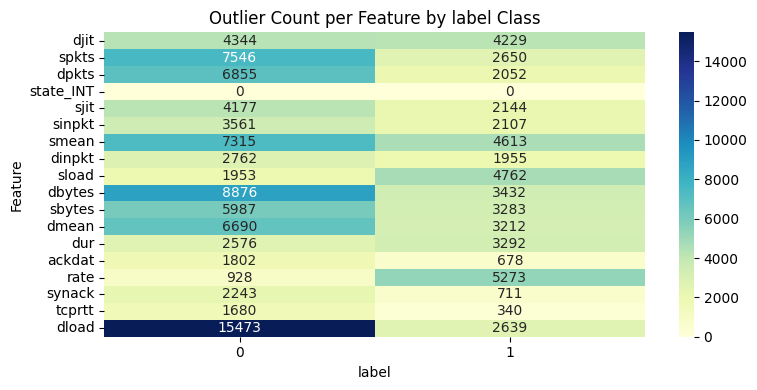

In [29]:
outlier_flags['label'] = test['label']

grouped_outliers = outlier_flags.groupby('label').sum().T  # Transpose for better readability

plt.figure(figsize=(8, 4))
sns.heatmap(grouped_outliers, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Outlier Count per Feature by label Class')
plt.ylabel('Feature')
plt.xlabel('label')
plt.tight_layout()
plt.show()


In [30]:
skewness = test.drop(columns = 'label').skew()
skewness = skewness.sort_values(ascending = False)
skewness

,0
state_RST,286.935533
trans_depth,170.794394
service_irc,128.312119
service_radius,95.631236
response_body_len,74.635200
djit,60.562279
service_dhcp,56.247053
dloss,54.465649
sbytes,53.778546
service_snmp,53.255405


In [31]:
numerical_cols_to_transform = skewness[skewness > 1].index.tolist()

for col in numerical_cols_to_transform:
    if col in x_train.columns:
        x_train[col] = np.log1p(x_train[col])

    if col in x_test.columns:
        x_test[col] = np.log1p(x_test[col])


In [32]:
test = pd.concat([x_test, y_test], axis = 1)

skewness = test.drop(columns = 'label').skew()
skewness = skewness.sort_values(ascending = False)
skewness

,0
synack,6.419753
ackdat,5.082881
tcprtt,3.756920
dur,3.224474
smean,1.909332
sbytes,1.114123
spkts,1.075176
sinpkt,0.962919
dinpkt,0.749781
dpkts,0.692811


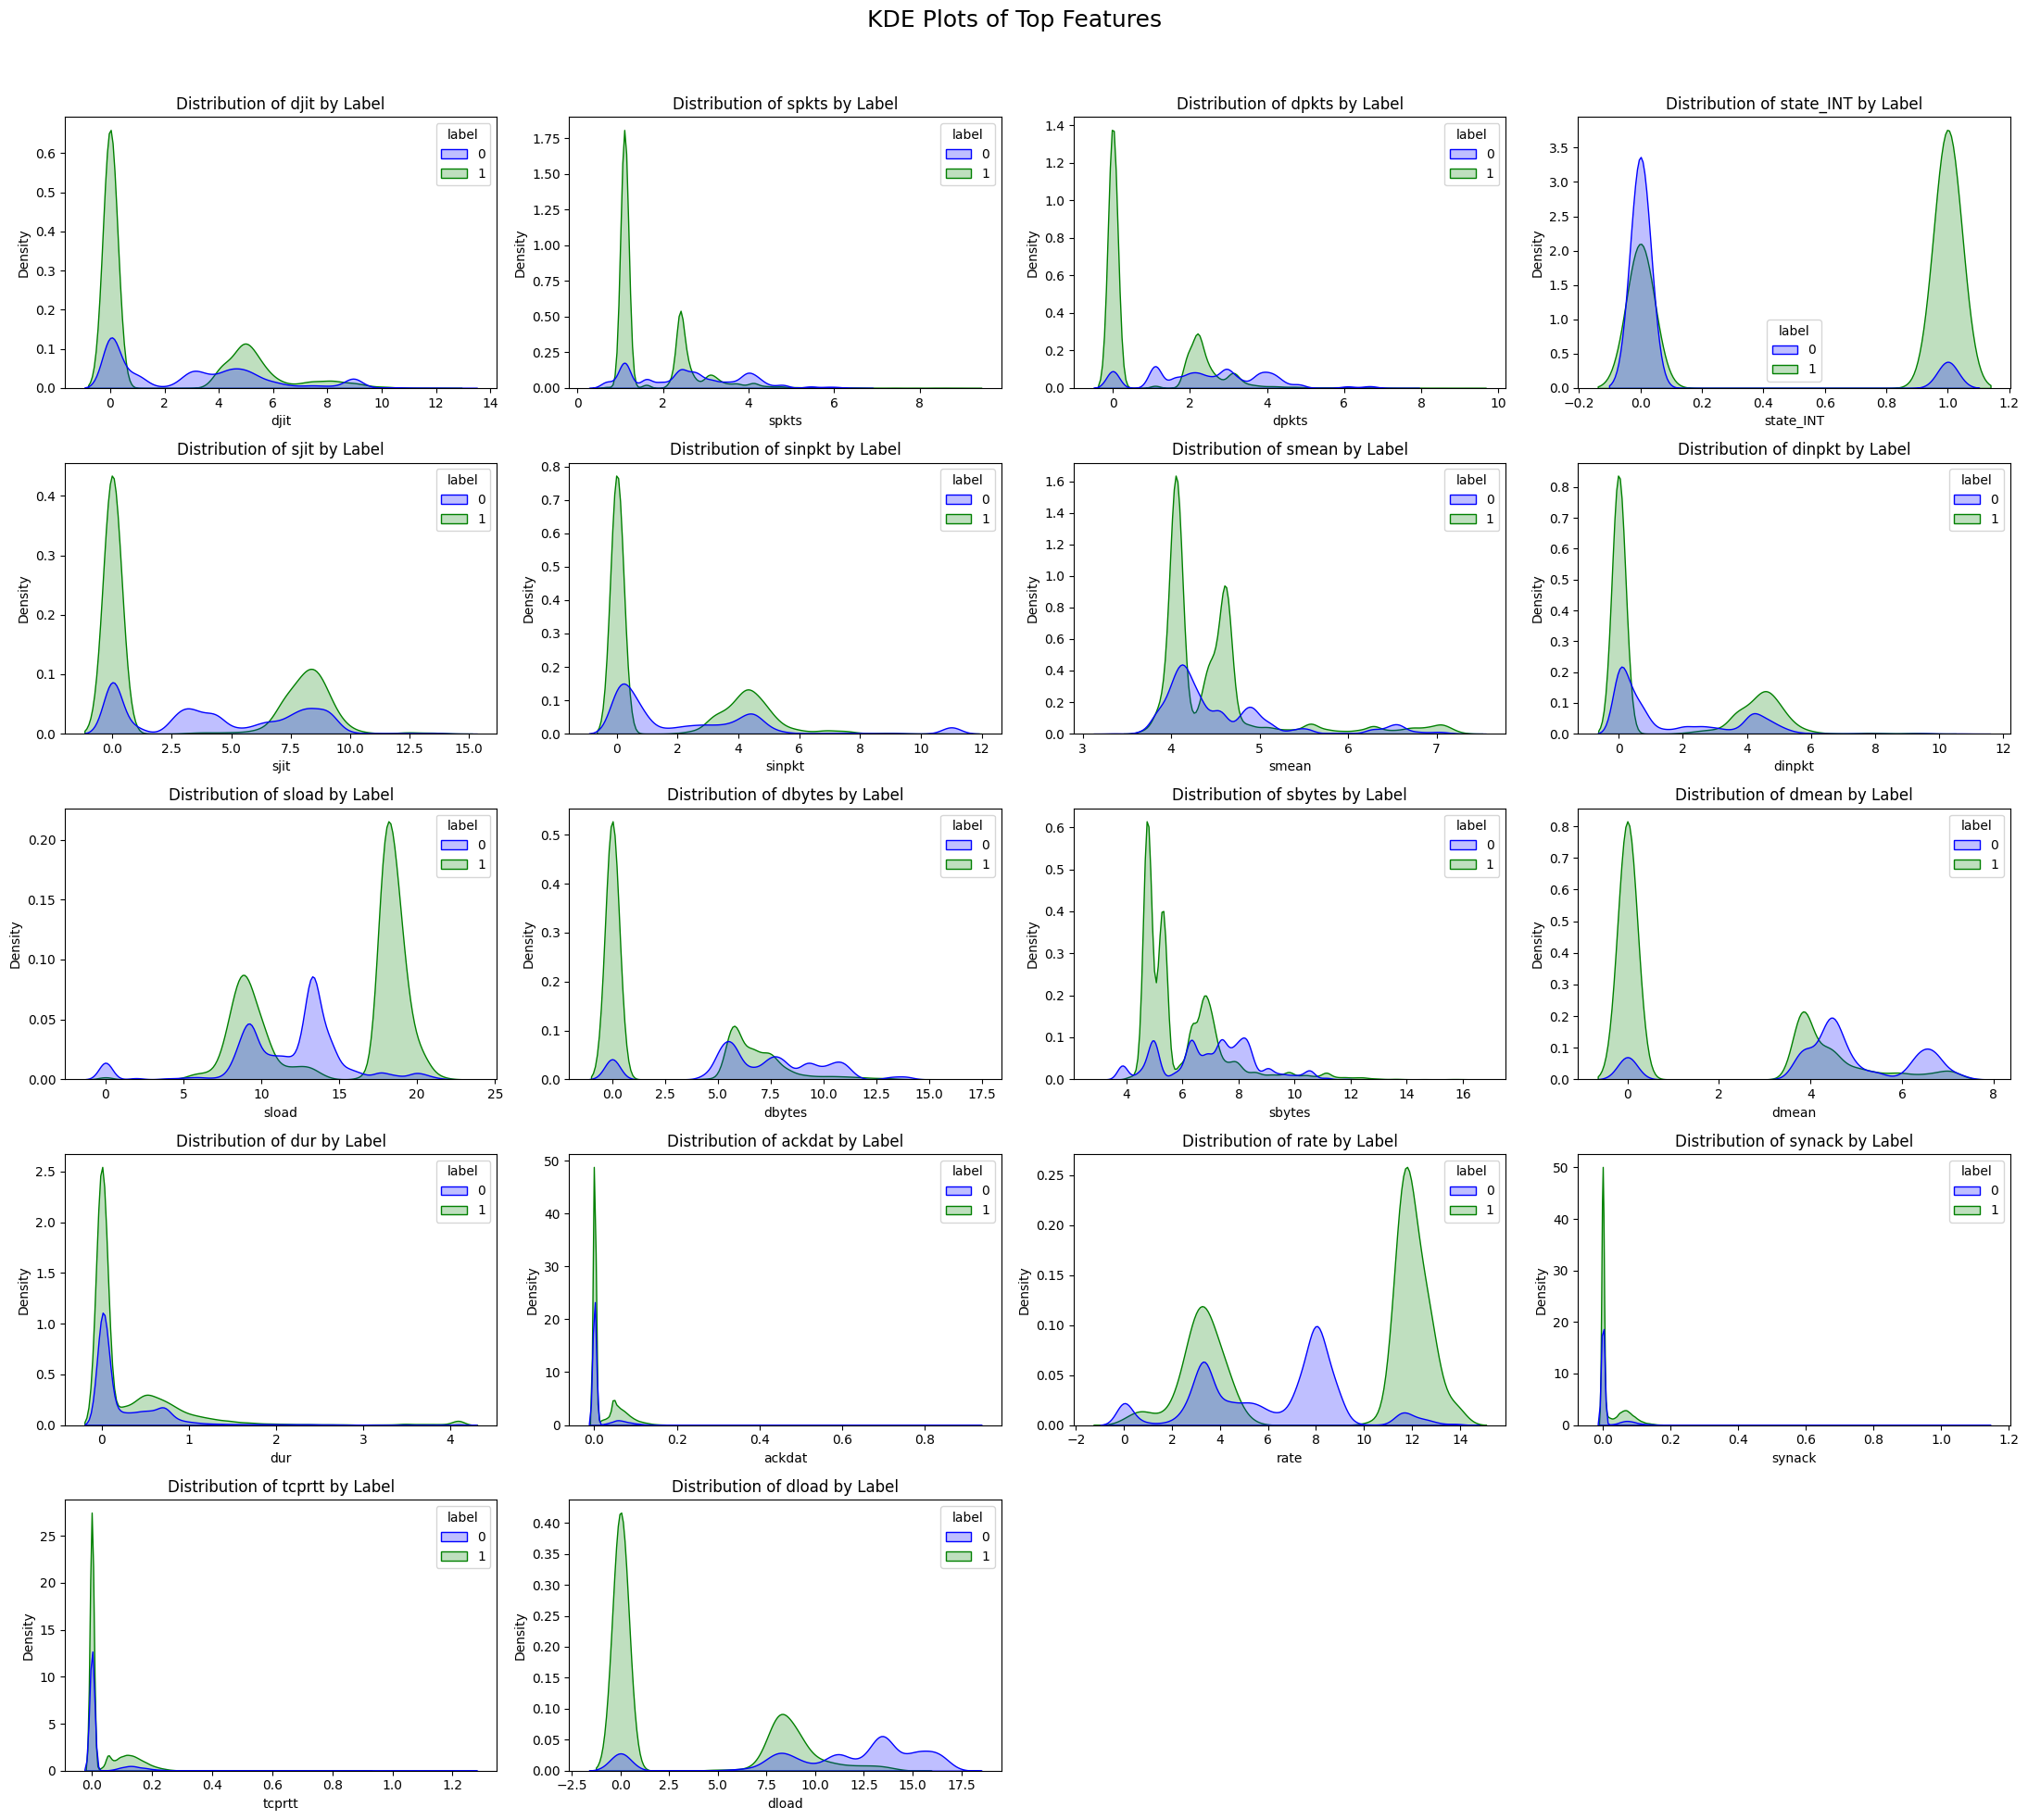

In [33]:
temp = pd.concat([x_train, y_train], axis = 1)

features = temp.columns[:-1]
n_features = len(features)

rows = 5 # Increased from 5 to accommodate all features
cols = 4


fig, axes = plt.subplots(rows, cols, figsize=(22, 20))
fig.suptitle('KDE Plots of Top Features', fontsize=18)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i] # Use the flattened index
    sns.kdeplot(data = temp, x = feature, hue='label', fill = True, ax = ax, palette={0: 'blue', 1: 'green'})
    ax.set_title(f'Distribution of {feature} by Label')

# Hide any unused subplots
for j in range(n_features, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()

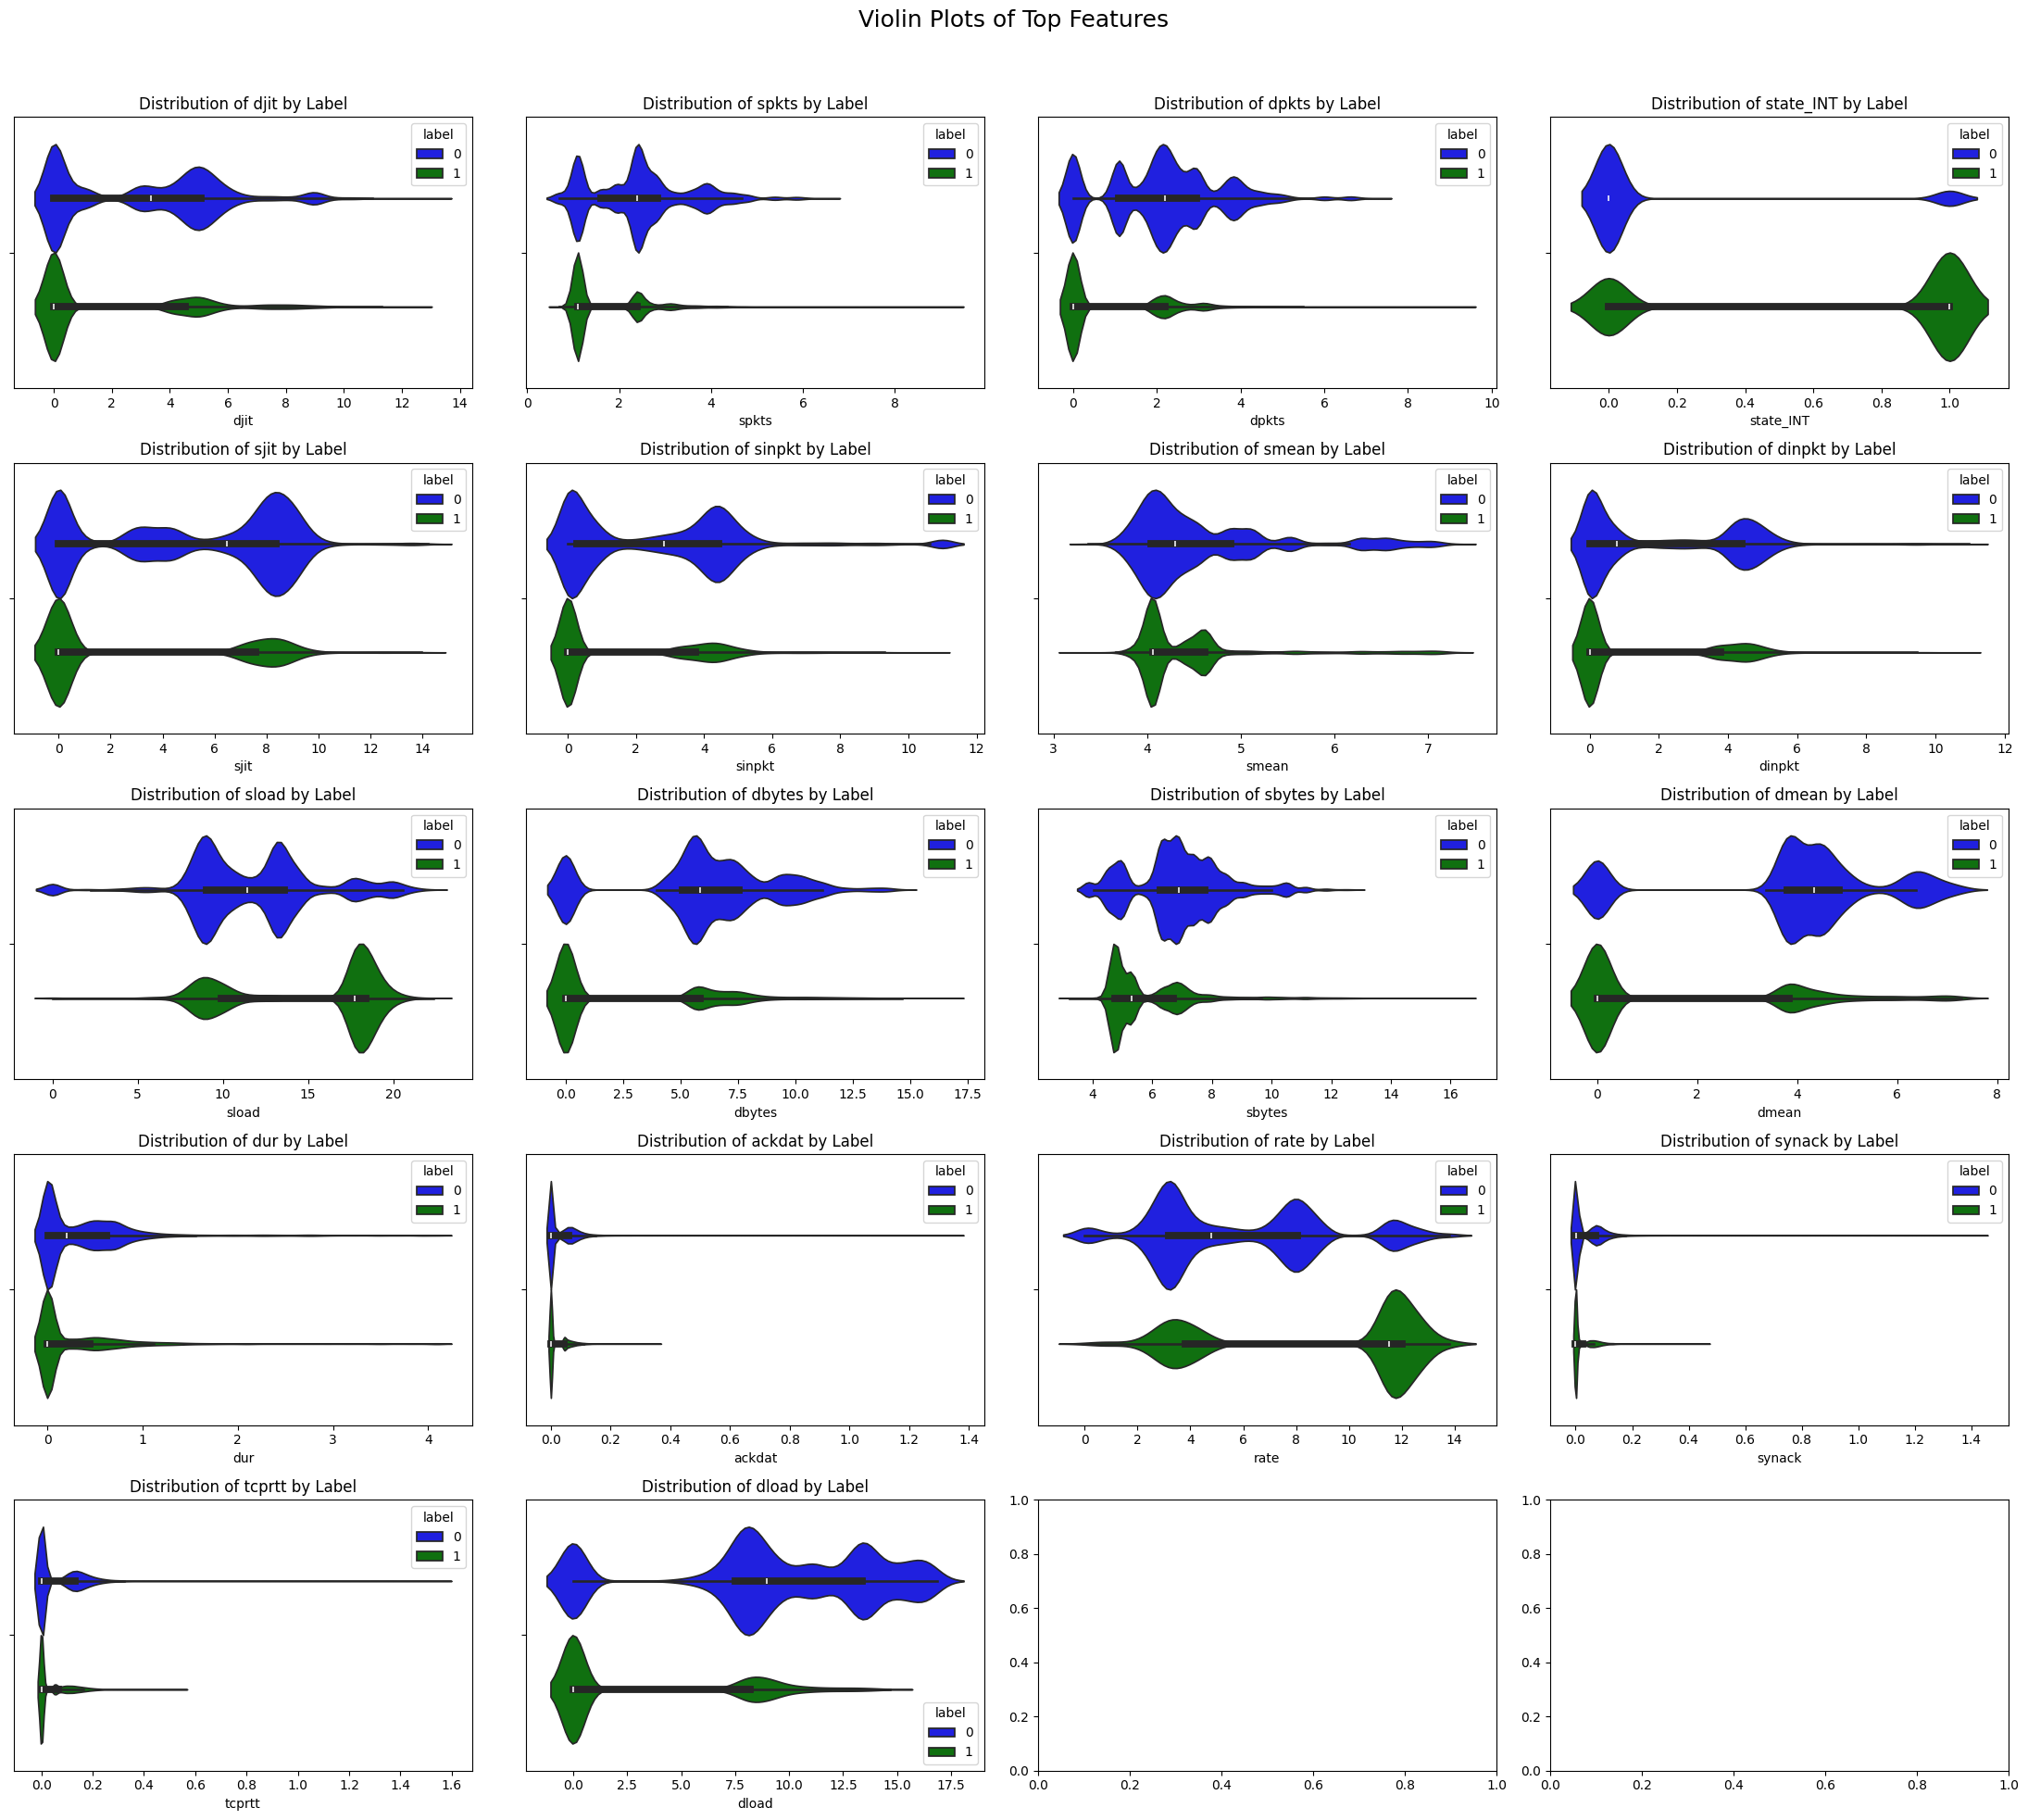

In [34]:
fig, axes = plt.subplots(rows, cols, figsize=(22, 20))
fig.suptitle('Violin Plots of Top Features', fontsize=18)

for i, feature in enumerate(features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    sns.violinplot(data = test, x = feature, hue='label', fill = True, ax = ax, palette={0: 'blue', 1: 'green'})
    axes[row, col].set_title(f'Distribution of {feature} by Label')


plt.tight_layout(rect = [0, 0, 1, 0.96])
plt.show()




In [35]:
binary_cols = [
    col for col in x_train.columns if x_train[col].dropna().nunique() == 2 and
    set(x_train[col].dropna().unique()).issubset({0,1})
]

numeric_cols = [
    col for col in x_train.columns if x_train[col].dropna().nunique() > 2 and
    set(x_train[col].dropna().unique()).issubset({0,1}) == False
]


print(f"Binary columns: {len(binary_cols)}")
print(f"Numeric columns: {len(numeric_cols)}")


Binary columns: 1
Numeric columns: 17


In [36]:
scaler = StandardScaler()
x_train_numeric_scaled = scaler.fit_transform(x_train[numeric_cols])
x_test_numeric_scaled = scaler.transform(x_test[numeric_cols])

x_train_norm = pd.DataFrame(x_train_numeric_scaled, columns = numeric_cols, index = x_train.index)
x_test_norm = pd.DataFrame(x_test_numeric_scaled, columns = numeric_cols, index = x_test.index)

x_train_norm = pd.concat([x_train_norm, x_train[binary_cols]], axis = 1)
x_test_norm = pd.concat([x_test_norm, x_test[binary_cols]], axis = 1)

In [37]:
x_train_norm.head()

,djit,spkts,dpkts,sjit,sinpkt,smean,dinpkt,sload,dbytes,sbytes,dmean,dur,ackdat,rate,synack,tcprtt,dload,state_INT
0,0.104541,-0.068307,0.140261,-0.010753,0.557654,-1.026500,0.311256,-0.937019,0.334160,-0.441590,0.506480,-0.342123,-0.528664,-0.852011,-0.510116,-0.550668,0.591119,0
1,1.754712,0.597577,1.463624,0.167339,0.845584,-0.766009,0.576559,-1.049058,1.720441,0.188354,1.782708,0.247757,-0.528664,-0.838341,-0.510116,-0.550668,1.295137,0
2,2.496991,0.151267,0.928674,1.608269,1.471368,-0.934177,1.447565,-1.408041,1.427966,-0.234394,1.666361,0.956178,0.808064,-1.237125,1.011431,0.985107,0.930891,0
3,2.205470,0.472549,0.755846,0.533371,1.300817,-0.766009,1.386862,-1.289018,0.711339,0.094296,0.660882,0.989886,-0.528664,-1.245081,-0.510116,-0.550668,0.431105,0
4,0.882603,0.326594,0.357032,1.105180,0.827701,-0.739845,1.304577,-1.044852,0.445572,-0.003462,0.524070,0.049848,0.983219,-1.040160,1.243236,1.198187,0.460678,0


In [38]:
print(x_train_norm.shape)
print(x_test_norm.shape)

(175341, 18)
(82332, 18)


In [39]:
x_train_norm

,djit,spkts,dpkts,sjit,sinpkt,smean,dinpkt,sload,dbytes,sbytes,dmean,dur,ackdat,rate,synack,tcprtt,dload,state_INT
0,0.104541,-0.068307,0.140261,-0.010753,0.557654,-1.026500,0.311256,-0.937019,0.334160,-0.441590,0.506480,-0.342123,-0.528664,-0.852011,-0.510116,-0.550668,0.591119,0
1,1.754712,0.597577,1.463624,0.167339,0.845584,-0.766009,0.576559,-1.049058,1.720441,0.188354,1.782708,0.247757,-0.528664,-0.838341,-0.510116,-0.550668,1.295137,0
2,2.496991,0.151267,0.928674,1.608269,1.471368,-0.934177,1.447565,-1.408041,1.427966,-0.234394,1.666361,0.956178,0.808064,-1.237125,1.011431,0.985107,0.930891,0
3,2.205470,0.472549,0.755846,0.533371,1.300817,-0.766009,1.386862,-1.289018,0.711339,0.094296,0.660882,0.989886,-0.528664,-1.245081,-0.510116,-0.550668,0.431105,0
4,0.882603,0.326594,0.357032,1.105180,0.827701,-0.739845,1.304577,-1.044852,0.445572,-0.003462,0.524070,0.049848,0.983219,-1.040160,1.243236,1.198187,0.460678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,-0.794402,-0.808594,-0.896615,-0.893055,-0.768405,-0.639823,-0.746692,0.817068,-0.966509,-0.931933,-0.990934,-0.517281,-0.528664,0.905728,-0.510116,-0.550668,-0.969240,1
175337,0.895544,0.326594,0.518940,1.215944,0.880333,-0.524078,1.247779,-1.038323,0.515589,0.086565,0.515373,0.108080,1.119340,-1.038493,0.414154,0.821975,0.496352,0
175338,-0.794402,-0.808594,-0.896615,-0.893055,-0.768405,-0.639823,-0.746692,0.817068,-0.966509,-0.931933,-0.990934,-0.517281,-0.528664,0.905728,-0.510116,-0.550668,-0.969240,1
175339,-0.794402,-0.808594,-0.896615,-0.893055,-0.768405,-0.639823,-0.746692,0.817068,-0.966509,-0.931933,-0.990934,-0.517281,-0.528664,0.905728,-0.510116,-0.550668,-0.969240,1


In [40]:
x_test_norm.head(5)

,djit,spkts,dpkts,sjit,sinpkt,smean,dinpkt,sload,dbytes,sbytes,dmean,dur,ackdat,rate,synack,tcprtt,dload,state_INT
0,-0.794402,-0.808594,-0.896615,-0.893055,-0.767590,1.399583,-0.746692,1.089252,-0.966509,-0.047959,-0.990934,-0.517278,-0.528664,0.857408,-0.510116,-0.550668,-0.96924,1
1,-0.794402,-0.808594,-0.896615,-0.893055,-0.768813,3.169863,-0.746692,1.429258,-0.966509,0.716750,-0.990934,-0.517282,-0.528664,0.934090,-0.510116,-0.550668,-0.96924,1
2,-0.794402,-0.808594,-0.896615,-0.893055,-0.770040,2.470108,-0.746692,1.422685,-0.966509,0.414598,-0.990934,-0.517287,-0.528664,1.047265,-0.510116,-0.550668,-0.96924,1
3,-0.794402,-0.808594,-0.896615,-0.893055,-0.769630,2.231037,-0.746692,1.346913,-0.966509,0.311339,-0.990934,-0.517285,-0.528664,1.003363,-0.510116,-0.550668,-0.96924,1
4,-0.794402,-0.808594,-0.896615,-0.893055,-0.767997,3.432448,-0.746692,1.421680,-0.966509,0.830108,-0.990934,-0.517279,-0.528664,0.880358,-0.510116,-0.550668,-0.96924,1


In [41]:
print(x_train_norm.shape)
print(x_test_norm.shape)

(175341, 18)
(82332, 18)


In [42]:
x_train_norm_series = x_train_norm.values.reshape(x_train_norm.shape[0], 1, x_train_norm.shape[1])
x_test_norm_series = x_test_norm.values.reshape(x_test_norm.shape[0], 1, x_test_norm.shape[1])

In [43]:
x_train_norm_series.shape

(175341, 1, 18)

In [44]:
proto_encoder = LabelEncoder()
proto_train_encoded = proto_encoder.fit_transform(proto_train)
proto_test_encoded = proto_encoder.transform(proto_test)

# Reshape for model input
proto_train_encoded = proto_train_encoded.reshape(-1, 1)
proto_test_encoded = proto_test_encoded.reshape(-1, 1)

proto_vocab_size = len(proto_encoder.classes_)
embedding_dim = int(proto_vocab_size**0.25)

print(f"Proto vocabulary size: {proto_vocab_size}")
print(f"Embedding dimension: {embedding_dim}")

Proto vocabulary size: 133
Embedding dimension: 3


In [45]:
x_train_tensor = torch.tensor(x_train_norm.values, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.float32).unsqueeze(1) # Unsqueeze for BCELoss
x_test_tensor = torch.tensor(x_test_norm.values, dtype = torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.float32).unsqueeze(1) # Unsqueeze for BCELoss

proto_train_tensor = torch.tensor(proto_train_encoded, dtype = torch.long)
proto_test_tensor = torch.tensor(proto_test_encoded, dtype = torch.long)

x_train_tensor = x_train_tensor.unsqueeze(1)
x_test_tensor = x_test_tensor.unsqueeze(1)


print("Data converted to PyTorch tensors.")
print("x_train_tensor shape:", x_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)
print("x_test_tensor shape:", x_test_tensor.shape)
print("y_test_tensor shape:", y_test_tensor.shape)
print("proto_train_tensor shape:", proto_train_tensor.shape)
print("proto_test_tensor shape:", proto_test_tensor.shape)

Data converted to PyTorch tensors.
x_train_tensor shape: torch.Size([175341, 1, 18])
y_train_tensor shape: torch.Size([175341, 1])
x_test_tensor shape: torch.Size([82332, 1, 18])
y_test_tensor shape: torch.Size([82332, 1])
proto_train_tensor shape: torch.Size([175341, 1])
proto_test_tensor shape: torch.Size([82332, 1])


# Model

In [46]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.supports_masking = True
        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0

        self.weight = nn.Parameter(torch.Tensor(feature_dim, 1))
        if bias:
            self.b = nn.Parameter(torch.Tensor(step_dim))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias:
            nn.init.zeros_(self.b)

    def forward(self, x, mask=None):
        eij = torch.matmul(x, self.weight).squeeze(2)

        if self.bias:
            eij = eij + self.b

        eij = torch.tanh(eij)
        a = softmax(eij, dim=1)

        if mask is not None:
            a = a * mask
            a = a / torch.sum(a, dim=1, keepdim=True)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, dim=1)

class MultiInputModel_WithSigmoid(nn.Module):
    def __init__(self, other_features_dim, proto_vocab_size, embedding_dim):
        super(MultiInputModel_WithSigmoid, self).__init__()

        self.proto_embedding = nn.Embedding(num_embeddings=proto_vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=other_features_dim, hidden_size=64, batch_first=True, bidirectional=False)
        self.attention = Attention(feature_dim=64, step_dim=1)
        self.fc1 = nn.Linear(64 + embedding_dim, 32)
        self.relu = nn.GELU()
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, other_features, proto_feature):
        proto_embedded = self.proto_embedding(proto_feature.long()).squeeze(1)
        lstm_out, _ = self.lstm(other_features)
        attention_out = self.attention(lstm_out)
        concatenated = torch.cat((attention_out, proto_embedded), dim=1)
        x = self.fc1(concatenated)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        outputs = self.fc3(x)
        return outputs


other_features_dim = x_train_norm.shape[1]
proto_vocab_size = len(proto_encoder.classes_)
embedding_dim = int(proto_vocab_size ** 0.25)

print(other_features_dim)
print(proto_vocab_size)
embedding_dim



model = MultiInputModel_WithSigmoid(other_features_dim, proto_vocab_size, embedding_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


dummy_other_features = torch.randn(1, 1, other_features_dim).to(device)
dummy_proto_feature = torch.randint(0, proto_vocab_size, (1, 1)).to(device)


18
133


In [47]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"The model has {num_params} trainable parameters.")

def count_parameters_by_layer(model):
    total_params = 0
    print("Layer-wise parameter count:")

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            print(f"Layer: {name}, Parameters: {num_params}")
            total_params += num_params

    print(f"Total Trainable Parameters: {total_params}")

count_parameters_by_layer(model)

The model has 24689 trainable parameters.
Layer-wise parameter count:
Layer: proto_embedding.weight, Parameters: 399
Layer: lstm.weight_ih_l0, Parameters: 4608
Layer: lstm.weight_hh_l0, Parameters: 16384
Layer: lstm.bias_ih_l0, Parameters: 256
Layer: lstm.bias_hh_l0, Parameters: 256
Layer: attention.weight, Parameters: 64
Layer: attention.b, Parameters: 1
Layer: fc1.weight, Parameters: 2144
Layer: fc1.bias, Parameters: 32
Layer: fc2.weight, Parameters: 512
Layer: fc2.bias, Parameters: 16
Layer: fc3.weight, Parameters: 16
Layer: fc3.bias, Parameters: 1
Total Trainable Parameters: 24689


# Train

In [48]:
class TrafficDataset(Dataset):
    def __init__(self, other_features, proto_feature, labels):
        self.other_features = other_features
        self.proto_feature = proto_feature
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.other_features[idx], self.proto_feature[idx], self.labels[idx]


train_dataset = TrafficDataset(x_train_tensor, proto_train_tensor, y_train_tensor)
test_dataset = TrafficDataset(x_test_tensor, proto_test_tensor, y_test_tensor)

batch_size = 512

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

print("\nPyTorch DataLoaders created.")
print("Number of training batches:", len(train_dataloader))
print("Number of testing batches:", len(test_dataloader))


PyTorch DataLoaders created.
Number of training batches: 343
Number of testing batches: 161


In [49]:
print(f"Using device: {device}")

class_counts = y_train.value_counts()
total_samples = len(y_train)

pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_tensor = torch.tensor([pos_weight_val], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training loop
num_epochs = 50

# train_losses = []
# test_losses = []
# test_accuracies = []

train_losses = []
test_losses = []
test_accuracies = []
test_specificities = []
test_recalls = []
test_precisions = []
test_f1_scores = []
test_roc_aucs = []
test_pr_aucs = []

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0

    for other_features, proto_feature, labels in train_dataloader:
        other_features, proto_feature, labels = other_features.to(device), proto_feature.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(other_features, proto_feature)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Evaluation loop
    model.eval()

    running_test_loss = 0.0
    all_test_labels = []
    all_test_predictions = []
    all_test_probabilities = []

    with torch.no_grad():
        for other_features, proto_feature, labels in test_dataloader:
            other_features, proto_feature, labels = other_features.to(device), proto_feature.to(device), labels.to(device)
            outputs = model(other_features, proto_feature)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * labels.size(0)

            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.35).float()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())
            all_test_probabilities.extend(probabilities.cpu().numpy())

    epoch_test_loss = running_test_loss / len(test_dataset)
    test_losses.append(epoch_test_loss)

    all_test_labels = np.array(all_test_labels).squeeze()
    all_test_predictions = np.array(all_test_predictions).squeeze()
    all_test_probabilities = np.array(all_test_probabilities).squeeze()


    epoch_test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
    test_accuracies.append(epoch_test_accuracy)
    epoch_test_precision = precision_score(all_test_labels, all_test_predictions)
    epoch_test_recall = recall_score(all_test_labels, all_test_predictions)
    epoch_test_f1 = f1_score(all_test_labels, all_test_predictions)

    tn, fp, fn, tp = confusion_matrix(all_test_labels, all_test_predictions).ravel()
    specificity = tn / (tn + fp)
    test_specificities.append(specificity)

    try:
        roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)
        test_roc_aucs.append(roc_auc)
    except ValueError:
        test_roc_aucs.append(np.nan) # Handle cases where AUC cannot be calculated

    precision_vals, recall_vals, _ = precision_recall_curve(all_test_labels, all_test_probabilities)
    pr_auc = auc(recall_vals, precision_vals)
    test_pr_aucs.append(pr_auc)


    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}, Test Precision: {epoch_test_precision:.4f}, Test Recall: {epoch_test_recall:.4f}, Test F1-score: {epoch_test_f1:.4f}')

print("\nTraining finished.")

Using device: cuda
Epoch [1/50], Train Loss: 0.4069, Test Loss: 0.3870, Test Accuracy: 0.6640, Test Precision: 0.6314, Test Recall: 0.9366, Test F1-score: 0.7543
Epoch [2/50], Train Loss: 0.2370, Test Loss: 0.3805, Test Accuracy: 0.7421, Test Precision: 0.6919, Test Recall: 0.9584, Test F1-score: 0.8036
Epoch [3/50], Train Loss: 0.1964, Test Loss: 0.3714, Test Accuracy: 0.7502, Test Precision: 0.6970, Test Recall: 0.9666, Test F1-score: 0.8099
Epoch [4/50], Train Loss: 0.1827, Test Loss: 0.3467, Test Accuracy: 0.7675, Test Precision: 0.7118, Test Recall: 0.9708, Test F1-score: 0.8214
Epoch [5/50], Train Loss: 0.1679, Test Loss: 0.3166, Test Accuracy: 0.7959, Test Precision: 0.7375, Test Recall: 0.9773, Test F1-score: 0.8406
Epoch [6/50], Train Loss: 0.1571, Test Loss: 0.3078, Test Accuracy: 0.8042, Test Precision: 0.7455, Test Recall: 0.9785, Test F1-score: 0.8463
Epoch [7/50], Train Loss: 0.1516, Test Loss: 0.2987, Test Accuracy: 0.8067, Test Precision: 0.7478, Test Recall: 0.9792, Te

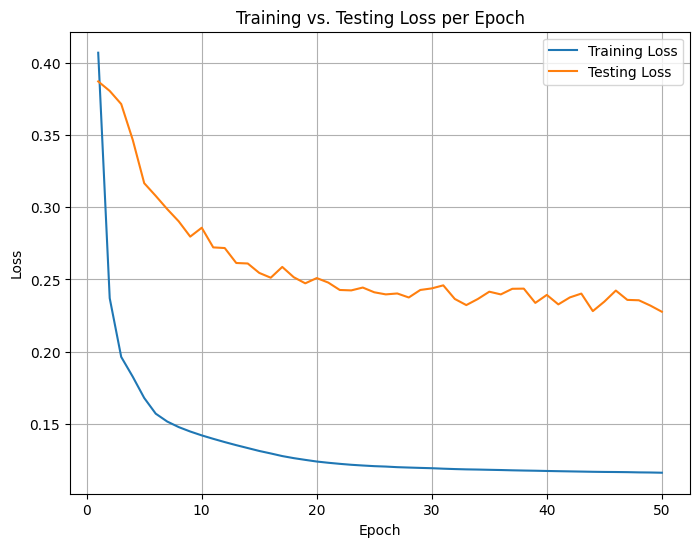

In [50]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.title('Training vs. Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Final Evaluation on Test Set:
Accuracy: 0.8255
Precision: 0.7655
Recall: 0.9847
F1-score: 0.8614
AUC-ROC: 0.9557
AUC-PR: 0.9661
Specificity (True Negative Rate): 0.6304
False Positive Rate: 0.3696


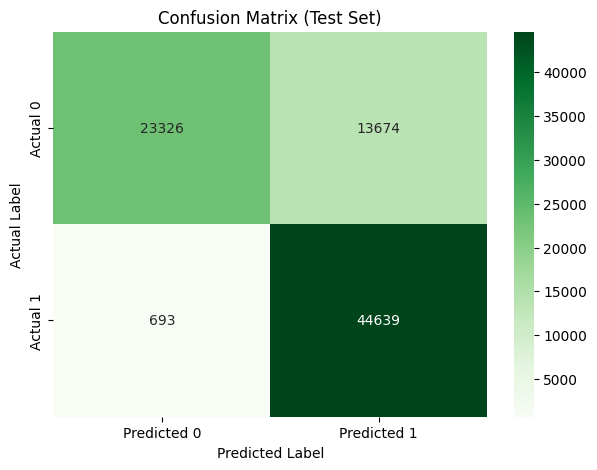

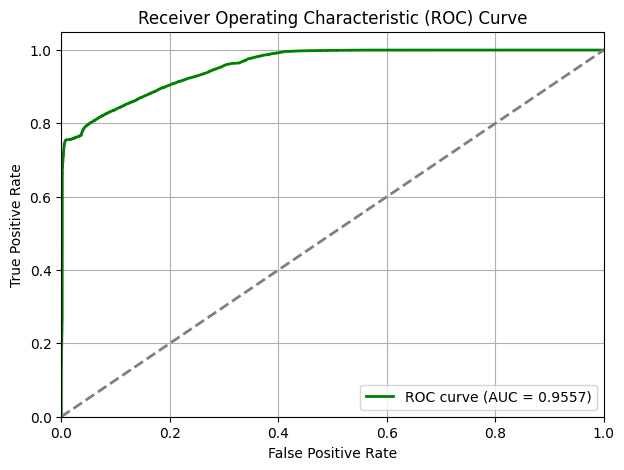

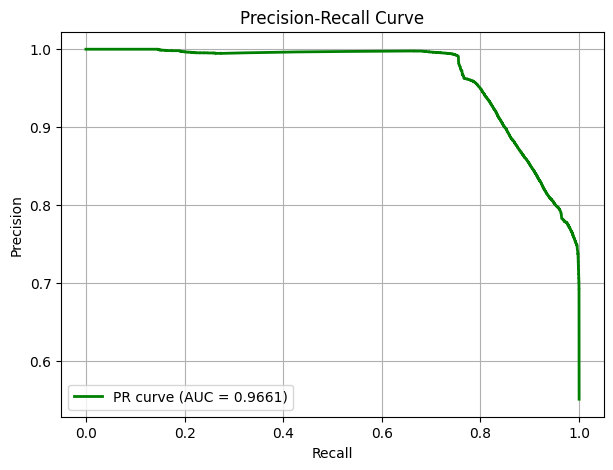

In [ ]:
# After training, calculate and display final metrics on the test set
print("\nFinal Evaluation on Test Set:")
final_accuracy = accuracy_score(all_test_labels, all_test_predictions)
final_precision = precision_score(all_test_labels, all_test_predictions)
final_recall = recall_score(all_test_labels, all_test_predictions)
final_f1 = f1_score(all_test_labels, all_test_predictions)
final_cm = confusion_matrix(all_test_labels, all_test_predictions)
final_roc_auc = roc_auc_score(all_test_labels, all_test_probabilities)


# Calculate Precision-Recall curve and AUC
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(all_test_labels, all_test_probabilities)
final_pr_auc = auc(recall_vals, precision_vals)



print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1-score: {final_f1:.4f}")
print(f"AUC-ROC: {final_roc_auc:.4f}")
print(f"AUC-PR: {final_pr_auc:.4f}")

tn, fp, fn, tp = final_cm.ravel()
specificity = tn / (tn + fp)
print(f"Specificity (True Negative Rate): {specificity:.4f}")

fpr_val = fp / (fp + tn)
print(f"False Positive Rate: {fpr_val:.4f}")


plt.figure(figsize=(7, 5))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()



# Plot ROC curve
fpr, tpr, thresholds_roc = roc_curve(all_test_labels, all_test_probabilities)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {final_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Plot Precision-Recall curve
plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, color='green', lw=2, label=f'PR curve (AUC = {final_pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()